In [8]:
import numpy as np
import pandas as pd

from sktime.forecasting.arch import ARCH
# from sktime.forecasting.arima import StatsModelsARIMA
# from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.utils.plotting import plot_series
# временной горизонт для прогнозирования
from sktime.forecasting.base import ForecastingHorizon

from sktime.split import temporal_train_test_split, ExpandingWindowSplitter, SlidingWindowSplitter, SingleWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError # Метрики MSE, MAE, MAPE

import pandas_datareader.data as web

# тесты диагностики
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [5]:
m2 = web.DataReader(name='WM2NS', data_source='fred', start='1995-01-01')
y = np.log(m2).diff().dropna()

In [6]:
y.shape

(1574, 1)

In [11]:
# Зададим список из специфицированных моделей прогнозирования
forecasters = [ARCH(mean='AR', lags=1, vol='GARCH', p=1, q=1, power=2), ARCH(mean='AR', lags=1, vol='GARCH', p=1, q=1, o=1, power=2),
               ARCH(mean='AR', lags=1, vol='EGARCH', p=1, q=1), ARCH(mean='AR', lags=1, vol='EGARCH', p=1, q=1, o=1),
               ARCH(mean='AR', lags=1, vol='APARCH', p=1, q=1, power=2),
               ARCH(mean='AR', lags=2, vol='GARCH', p=1, q=1, power=2), ARCH(mean='AR', lags=1, vol='GARCH', p=1, q=1, o=1, power=2),
               ARCH(mean='AR', lags=2, vol='EGARCH', p=1, q=1), ARCH(mean='AR', lags=1, vol='EGARCH', p=1, q=1, o=1),
               ARCH(mean='AR', lags=2, vol='APARCH', p=1, q=1, power=2)]
# специфицируем метод кросс-валидации. Например, SlidingWindowSplitter. ARCH хорошо работает на несколько сдвигов вперед
cv_strategy = SlidingWindowSplitter(fh=np.arange(1, 6), initial_window=300, step_length=10)

# инициализируем метрики
metric = [MeanSquaredError(square_root=False), MeanAbsoluteError(), MeanAbsolutePercentageError()]

# датафрейм с метриками по столбцам
cv_data = pd.DataFrame(data=None, columns=['MSE', 'MAE', 'MAPE'])

for model in forecasters:
	print(model)
	cv_res = evaluate(forecaster=model, y=y, cv=cv_strategy, strategy="refit", return_data=False, scoring=metric)
	# print(df.iloc[:,:len(metric)].mean()) # метрики для каждой модели
	cv_data.loc[len(cv_data.index)] = cv_res.iloc[:,[0,1,2]].mean().values

# результаты кросс-валидации в виде датафрейма
cv_data

ARCH(lags=1, mean='AR', power=2)
ARCH(lags=1, mean='AR', o=1, power=2)
ARCH(lags=1, mean='AR', vol='EGARCH')
ARCH(lags=1, mean='AR', o=1, vol='EGARCH')
ARCH(lags=1, mean='AR', power=2, vol='APARCH')
ARCH(lags=2, mean='AR', power=2)
ARCH(lags=1, mean='AR', o=1, power=2)
ARCH(lags=2, mean='AR', vol='EGARCH')
ARCH(lags=1, mean='AR', o=1, vol='EGARCH')
ARCH(lags=2, mean='AR', power=2, vol='APARCH')


,MSE,MAE,MAPE
0,3.758600e-05,4.490058e-03,2.184690e+00
1,4.475315e+01,3.121255e-01,1.175449e+02
2,6.259924e+41,3.613931e+19,4.784396e+23
3,9.507752e+42,1.711746e+20,1.910537e+23
4,3.722294e-05,4.465362e-03,2.215068e+00
5,4.510696e-05,4.868701e-03,2.945328e+00
6,4.475315e+01,3.121255e-01,1.175449e+02
7,1.279381e+54,4.530268e+25,1.055424e+28
8,9.507752e+42,1.711746e+20,1.910537e+23
9,1.796449e+05,1.898913e+01,4.226826e+03


In [14]:
# Индекс модели
for i in range(cv_data.shape[1]):
	print(f'{cv_data.columns[i]}: model #={cv_data.iloc[:,i].argmin()}')

MSE: model #=4
MAE: model #=4
MAPE: model #=0


<Axes: xlabel='DATE'>

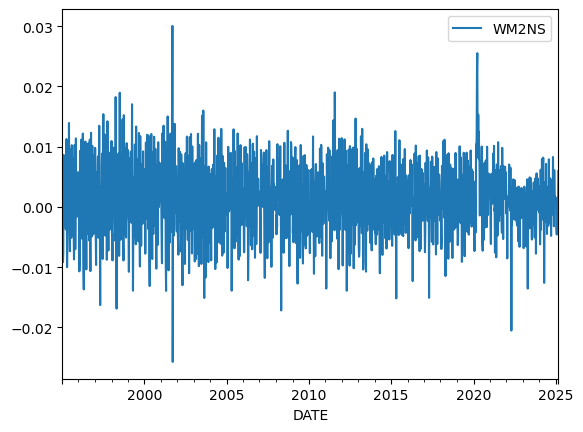

In [13]:
#MSE большие, так как некоторые скачки не были предсказаны
y.plot()

### Что лучше, нейросеть (rnn, LSTM) или ARIMA?

In [20]:
import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.neuralforecast import NeuralForecastRNN, NeuralForecastLSTM
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [41]:
m2 = web.DataReader(name='WM2NS', data_source='fred', start='1995-01-01')
y = np.log(m2)

<Axes: xlabel='DATE'>

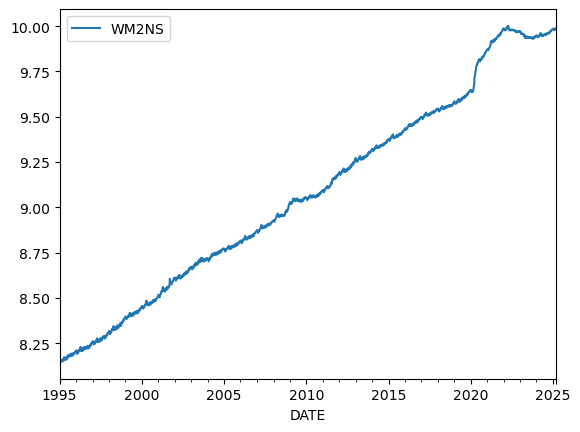

In [42]:
y.plot()

In [38]:
forecaster = AutoARIMA(information_criterion='bic', test='kpss', seasonal=False)
forecaster.fit(y)
forecaster.get_fitted_params() #['order']

{'intercept': 0.16517688124968985,
 'ar.L1': 0.3008026018482898,
 'ar.L2': -0.6789723194134915,
 'ar.L3': -0.2729224523719348,
 'ar.L4': 0.38872950939006534,
 'ar.L5': -0.2391096180100209,
 'ma.L1': -0.2794177808051037,
 'ma.L2': 0.9690256248145883,
 'sigma2': 0.15580535469911924,
 'order': (5, 0, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 1570.3558263212992,
 'aicc': 1570.4709158353658,
 'bic': 1618.6082051820954,
 'hqic': 1588.2882686172275}

#### Разделим на train и test

In [23]:
y_train, y_test = temporal_train_test_split(y, test_size=20)

In [25]:
forecaster = ARIMA(order=(3,1,4), trend='c')
y_predarima = forecaster.fit_predict(y_test, fh=y_test.index)

### Нейросеть

In [26]:
# max_steps - сколько раз будет прогоняться модель по методу градиентного спуска
model_rnn = NeuralForecastRNN("W-Mon", max_steps=15)

y_pred_rnn = model_rnn.fit_predict(y_train, fh=y_test.index)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: D:\work\Python\lightning_logs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 40.2 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

In [27]:
# max_steps - сколько раз будет прогоняться модель по методу градиентного спуска
model_lstm = NeuralForecastLSTM("W-Mon", max_steps=10)

y_pred_lstm = model_lstm.fit_predict(y_train, fh=y_test.index)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 40.2 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
526 K     Trainable params
0         Non-trainable params
526 K     Total params
2.106     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

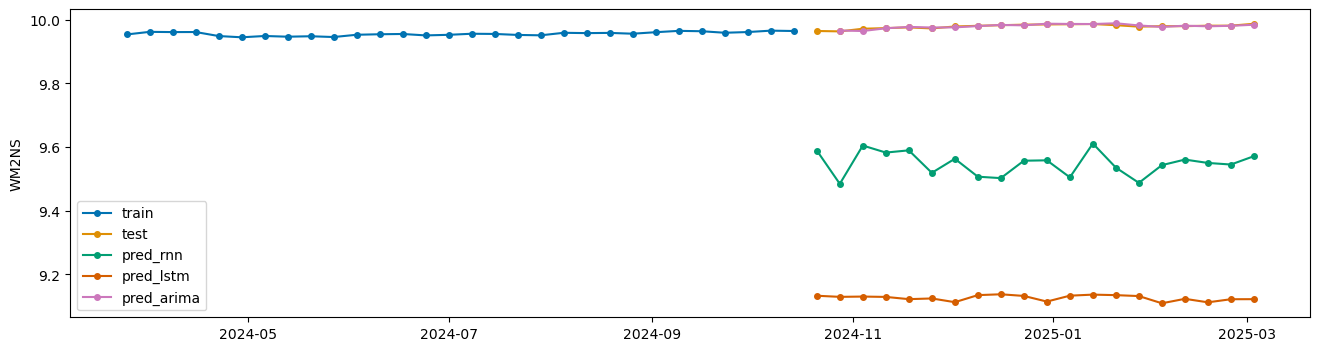

In [32]:
plot_series(y_train.tail(30), y_test, y_pred_rnn, y_pred_lstm, y_predarima, labels=['train', 'test', 'pred_rnn', 'pred_lstm', 'pred_arima'])

plt.show()

### Посмотрим, как будет вести себя модель, если взять первый дифференциал

In [56]:
m2 = web.DataReader(name='WM2NS', data_source='fred', start='1995-01-01')
y = np.log(m2).diff().dropna()*100 # можно домножить, если числа получаются слишком низкие

<Axes: xlabel='DATE'>

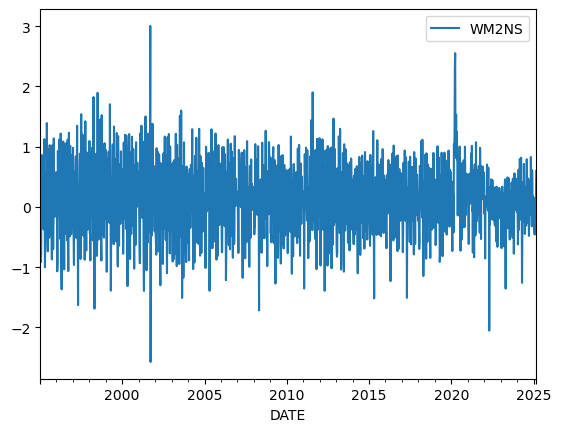

In [57]:
y.plot()

In [58]:
forecaster = AutoARIMA(information_criterion='bic', test='kpss', seasonal=False)
forecaster.fit(y)
forecaster.get_fitted_params() #['order']

{'intercept': 0.16517688124968985,
 'ar.L1': 0.3008026018482898,
 'ar.L2': -0.6789723194134915,
 'ar.L3': -0.2729224523719348,
 'ar.L4': 0.38872950939006534,
 'ar.L5': -0.2391096180100209,
 'ma.L1': -0.2794177808051037,
 'ma.L2': 0.9690256248145883,
 'sigma2': 0.15580535469911924,
 'order': (5, 0, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 1570.3558263212992,
 'aicc': 1570.4709158353658,
 'bic': 1618.6082051820954,
 'hqic': 1588.2882686172275}

In [59]:
y_train, y_test = temporal_train_test_split(y, test_size=20)

In [55]:
forecaster = ARIMA(order=(5,0,2), trend='c')
y_predarima = forecaster.fit_predict(y_test, fh=y_test.index)

In [61]:
# max_steps - сколько раз будет прогоняться модель по методу градиентного спуска
model_rnn = NeuralForecastRNN("W-Mon", max_steps=10)

y_pred_rnn = model_rnn.fit_predict(y_train, fh=y_test.index)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 40.2 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

In [62]:
# max_steps - сколько раз будет прогоняться модель по методу градиентного спуска
model_lstm = NeuralForecastLSTM("W-Mon", max_steps=10)

y_pred_lstm = model_lstm.fit_predict(y_train, fh=y_test.index)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 40.2 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
526 K     Trainable params
0         Non-trainable params
526 K     Total params
2.106     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

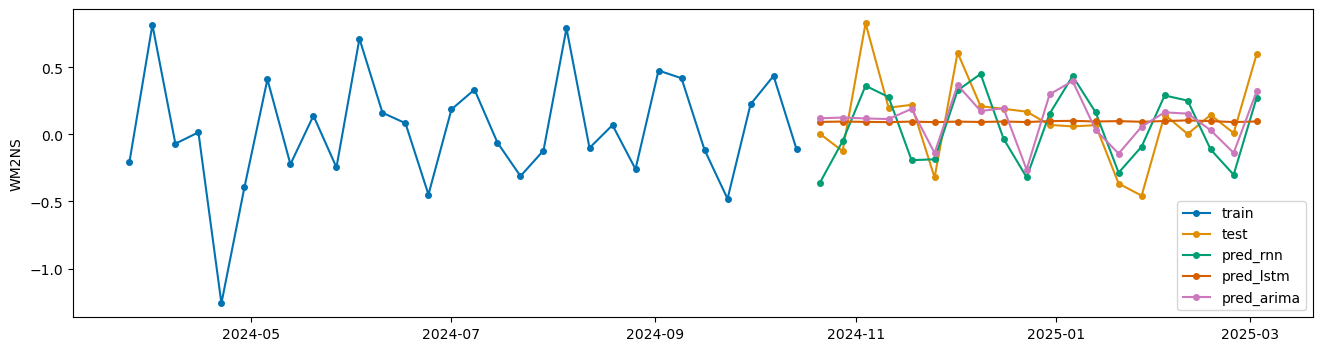

In [63]:
plot_series(y_train.tail(30), y_test, y_pred_rnn, y_pred_lstm, y_predarima, labels=['train', 'test', 'pred_rnn', 'pred_lstm', 'pred_arima'])

plt.show()

In [ ]:
metric = MeanSquaredError(square

## ДЗ: взять 1 разность и сравнить ARIMA со всеми ARCH моделями и LSTM (что лучше, ARIMA/GARCH или нейросети?)